
In a [previous post](https://www.jtrive.com/posts/intro-to-jax-part-1/intro-to-jax-part-1.html), I introduced JAX with particular emphasis on JIT compilation, vectorizing transformations and automatic differentiation. In this post, we walkthrough an implementation of the forward pass for a fully-connected neural network with the goal of classifying MNIST handwritten digits, incorporating concepts from the first post. 

We begin by loading MNIST training and validation sets, convert the PIL images to Numpy arrays, and create image-label batches of size 64:


In [1]:

import warnings

import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True, precision=5, linewidth=1000)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.precision", 5)
warnings.filterwarnings("ignore")

# Batch size.
bs = 64

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([ToTensor()])
)

valid_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=v2.Compose([ToTensor()])
)

# Convert PIL images to NumPy arrays.
train_data_arr = train_data.data.numpy() / 255.0      # Normalize pixel values to [0, 1]
valid_data_arr = valid_data.data.numpy() / 255.0      # Normalize pixel values to [0, 1] 
train_data_arr = train_data_arr.reshape(-1, 28 * 28)  # Flatten images to 1D arrays
valid_data_arr = valid_data_arr.reshape(-1, 28 * 28)  # Flatten images to 1D arrays
train_labels = train_data.targets.numpy()
valid_labels = valid_data.targets.numpy()

# Create training and validation batches of 64.
train_batches = [
    (train_data_arr[(bs * ii):(bs * (ii + 1))], train_labels[(bs * ii):(bs * (ii + 1))]) 
    for ii in range(len(train_data_arr) // bs)
]
valid_batches = [
    (valid_data_arr[(bs * ii):(bs * (ii + 1))], valid_labels[(bs * ii):(bs * (ii + 1))]) 
    for ii in range(len(valid_data_arr) // bs)
]

print(f"train_data_arr.shape: {train_data_arr.shape}")
print(f"valid_data_arr.shape: {valid_data_arr.shape}")
print(f"train_labels.shape  : {train_labels.shape}")
print(f"valid_labels.shape  : {valid_labels.shape}")
print(f"len(train_batches)  : {len(train_batches)}")
print(f"len(valid_batches)  : {len(valid_batches)}")


train_data_arr.shape: (60000, 784)
valid_data_arr.shape: (10000, 784)
train_labels.shape  : (60000,)
valid_labels.shape  : (10000,)
len(train_batches)  : 937
len(valid_batches)  : 156



<br>

We can visualize a batch of images and labels using matplotlib:

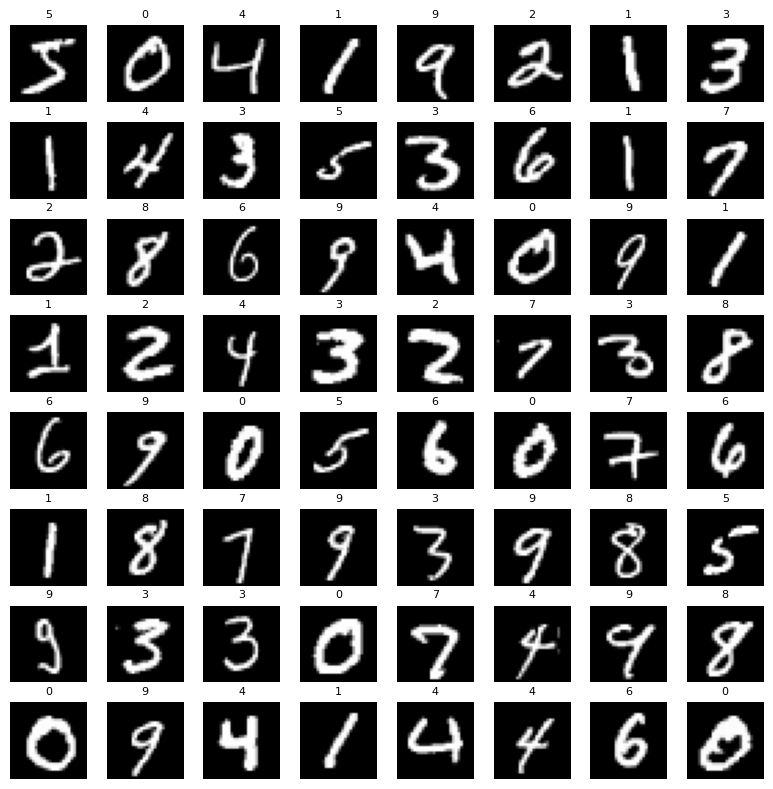

In [2]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

X, y = train_batches[0]
X = np.expand_dims(X.reshape(-1, 28, 28), 1)

fig = plt.figure(figsize=(8., 8.), tight_layout=False)

grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.20)

for ax, X_ii, y_ii in zip(grid, X, y):
    X_ii = np.transpose(X_ii, (1, 2, 0))
    ax.imshow(X_ii, cmap="gray")
    ax.axis("off")
    ax.set_title(f"{y_ii}", fontsize=8)

plt.show()




<br>

Our goal is to create a model that accepts a batch of 64 images, and returns a class prediction for each image in the batch. Our architecture is presented in the image below:

<p align="center">
  <img src="mnist.png"/>
</p>


<br>

The pre-activations for layer $l$ are computed as $Z^{(l)} = A^{(l-1)} W^{(l)} + b^{(l)}$, where:

- $Z^{(l)}$ = layer $l$ pre-activations (value prior to applying non-linearity like ReLU).
- $A^{(l-1)}$ = layer $l-1$ activations, with $A^{(0)}$ representing the original input. 
- $W^{(l)}$ = The weight matrix for layer $l$. 
- $b^{(l)}$ = bias vector for layer $l$.

<br>

For the network shown above assuming a batch size of 64:

- $Z^{(0)} = A^{(0)}$: Input matrix with dimension 64x784.
- $W^{(1)}$: Weight matrix with dimension 784x128.
- $b^{(1)}$ Bias vector of length 128. 
- $Z^{(1)} = A^{(0)} W^{(1)} + b^{(1)}$: Matrix of pre-activations with dimension 64x128.
- $A^{(1)}$: Non-linearity applied to $Z^{(1)}$. Activation matrix with dimension 64x128.
- $W^{(2)}$: Weight matrix with dimension 128x10.
- $b^{(2)}$: Bias vector of length 10. 
- $Z^{(2)} = A^{(1)} W^{(2)} + b^{(2)}$: Matrix of pre-activations with dimension 64x10.
- $A^{(2)}$: Non-linearity applied to $Z^{(2)}$. Activation matrix with dimension 64x10.


<br>

The forward pass feeds an image of size 28x28 into the network, which produces a probability distribution over all classes. The class with the highest probability is our class prediction, which for MNIST will be one of 10 digits 0-9. Specifically:

- Each 28x28 image is flattened to have shape 1x784. The input layer has the same size as the flattened image (784,).
- The hidden layer consists of 128 neurons. The matrix of weights projecting from the input layer to the first hidden layer has  dimension 784x128, plus a bias vector of length 128.
- The output layer consists of 10 neurons, which is the same the number of classes in the dataset. The matrix of weights projecting from the hidden layer to the output layer has dimension 128x10, along with a bias vector of length 10. 
- Applying softmax to the output layer results in a probability distribution over classes. 




Weight initialization is handled automatically in PyTorch, but when working in JAX, The first step is to initialize the network weights. We can create a helper function to assist with randomly assigning values to the weight matrices and bias vectors. 

In JAX, random number generation is handled a bit differently than in Numpy to ensure functional purity. JAX uses explicit PRNG keys to generate random numbers instead of relying on global state. A "key" is a special array that acts as a seed, and every time you use it, JAX produces the same random numbers for the same key.

Since JAX enforces immutability, you can't reuse a key for multiple random calls without getting the same result. Instead, you split a key using `jax.random.split`, which deterministically generates new, unique keys from the original one. Each split key is independent, allowing for the generation of different random numbers while maintaining reproducibility. 
In the next cell, we initialize weights using small random normal values:

In [3]:

from jax import random


def initialize_weights(sizes, key, scale=.02):
    """
    "Initialize weights and biases for each layer for simple fully-connected 
    network.

    Parameters
    ----------
    sizes : list of int
        List of integers representing the number of neurons in each layer.

    key : jax.random.PRNGKey
        Random key for JAX.

    Returns
    -------
    List of iniitialized weights and biases for each layer.
    """
    keys = random.split(key, len(sizes) - 1)
    params = []
    for m, n, k in zip(sizes[:-1], sizes[1:], keys):
        w_key, b_key = random.split(k)
        w = scale * random.normal(w_key, (m, n))
        b = scale * random.normal(b_key, (n,))
        params.append((w, b))
    return params


# Initialize weights and biases for each layer.
sizes = [784, 128, 10]

params = initialize_weights(sizes, key=random.PRNGKey(516), scale=.02)   

# Print shape of each layer's weights and biases.
print(f"W1 shape: {params[0][0].shape}")
print(f"b1 shape: {params[0][1].shape}")
print(f"W2 shape: {params[1][0].shape}")  
print(f"b2 shape: {params[1][1].shape}")


W1 shape: (784, 128)
b1 shape: (128,)
W2 shape: (128, 10)
b2 shape: (10,)



<br>

In PyTorch, models inherit from `nn.Module` and must implement a `forward` method that defines the network's computation flow. The forward method orchestrates how input tensors transform through pre-specified operations to produce outputs.

For our JAX implementation we'll create a similar function, but the weights must be explicitly passed as parameters rather than stored as internal state. Unlike PyTorch's object-oriented approach where weights are hidden properties of the model instance, JAX follows a functional paradigm that requires all state to be passed explicitly between function calls, eliminating hidden state.

In our `forward` function, we incorporate ReLU activation between layers to introduce non-linearity:


In [4]:

import jax.numpy as jnp
from jax.nn import relu


def forward(params, X):
    """
    Forward pass for simple fully-connected network.

    Parameters
    ----------
    params : list of tuples
        List of tuples containing weights and biases for each layer.

    X : jax.numpy.ndarray
        Input data.

    Returns
    -------
    jax.numpy.ndarray
    """
    a = X
    for W, b in params[:-1]:
        z = jnp.dot(a, W) + b
        a = relu(z)
    W, b = params[-1]
    return jnp.dot(a, W) + b



<br>

We can pass a single flattened image array into `forward`, and it should return a 1x10 vector of activations. The output will not be a probability distribution since softmax hasn't been applied, but we can still test it to ensure that the shape of the output is consistent with our expectations:

In [5]:

# Get first image from first training batch.
X, y = train_batches[0]

# Convert to JAX array.
X0 = jnp.asarray(X[0].flatten())

# Pass X0 into forward.
ypred = forward(params, X0)

print(f"ypred.shape: {ypred.shape}")
print(f"ypred: {ypred}")


ypred.shape: (10,)
ypred: [-0.01938  0.04435  0.01545  0.01266  0.00116 -0.07045 -0.03737  0.00276  0.01255 -0.00883]



<br>

### Auto-Vectorizing the Forward Pass


As implmented, `forward` is only capable of processing a single flattened image at a time. However, we can use `vmap`, introduced in the first post, to process a batch of images at a time without any modification to `forward`. `vmap` enables batch processing while taking advantage of JAX’s optimized execution. Instead of using loops, it efficiently maps a function over an array along a pre-specified axis:

In [6]:

from jax import vmap

batch_forward = vmap(forward, in_axes=(None, 0))



<br>

`in_axes` controls which input array axes to vectorize over, and its length must equal the number of positional arguments associated with the original function. In our case, the first argument to `forward` is `params`, which stays the same within the context of the forward pass. The second argument corresponds to our input image, and the '0' indicates that vectorization should be applied along the 0th axis (which is batch dimension).

We can pass a batch of size 64 x 784 into `batch_forward`, and return an output of size 64x10:

In [7]:

# Get first batch of flattened training images.
X, y = train_batches[0]

ypreds = batch_forward(params, X)

print(f"ypreds.shape: {ypreds.shape}")
print(f"ypreds:\n{ypreds}")


ypreds.shape: (64, 10)
ypreds:
[[-0.01938  0.04435  0.01545  0.01266  0.00116 -0.07045 -0.03737  0.00276  0.01255 -0.00883]
 [ 0.00129  0.0109   0.00602 -0.00877 -0.01916 -0.05659 -0.0483  -0.02185 -0.02209  0.01736]
 [-0.02005  0.00758  0.02579 -0.03333  0.00352 -0.0578  -0.04556 -0.0556  -0.04529  0.06416]
 [ 0.02695  0.00363  0.02104 -0.00848  0.03085 -0.06641 -0.03336 -0.01503 -0.04532  0.0081 ]
 [-0.02473 -0.01859  0.04075 -0.00455  0.01993 -0.04665 -0.03698 -0.0063  -0.03235  0.03909]
 [-0.02891  0.02183  0.01171 -0.00624  0.02155 -0.07441 -0.04383 -0.01707 -0.01268  0.02351]
 [ 0.01002 -0.01742  0.01145 -0.03244  0.01756 -0.04202 -0.04045 -0.03138 -0.01564  0.03871]
 [-0.01686  0.04742  0.04909  0.01424 -0.00733 -0.04773 -0.0763  -0.03617  0.01079  0.0016 ]
 [ 0.00961 -0.00337  0.01458 -0.01242  0.01239 -0.03938 -0.01167 -0.01025 -0.02025  0.03112]
 [-0.00639 -0.01172  0.04447 -0.0033   0.0276  -0.08083 -0.0409  -0.023   -0.03266  0.03201]
 [-0.01249  0.02364  0.03073 -0.0103   


<br>

To ensure each row sums to 1, we can apply softmax to `ypreds`:

In [8]:

from jax.nn import softmax

yprobs = softmax(ypreds, axis=1)

print(f"yprobs.shape: {yprobs.shape}")
print(f"yprobs:\n{yprobs}")


yprobs.shape: (64, 10)
yprobs:
[[0.0985  0.10498 0.10199 0.10171 0.10054 0.09359 0.09674 0.1007  0.10169 0.09954]
 [0.10153 0.10251 0.10201 0.10051 0.09947 0.09582 0.09661 0.0992  0.09918 0.10317]
 [0.09949 0.10228 0.10416 0.09818 0.10186 0.0958  0.09698 0.09601 0.09701 0.10823]
 [0.10349 0.1011  0.10288 0.09988 0.10389 0.09426 0.09743 0.09923 0.09627 0.10155]
 [0.0982  0.09881 0.10485 0.1002  0.10269 0.09607 0.09701 0.10003 0.09746 0.10468]
 [0.09813 0.10323 0.10219 0.10038 0.1032  0.09376 0.09667 0.09929 0.09973 0.10341]
 [0.102   0.09924 0.10215 0.09776 0.10277 0.09683 0.09698 0.09787 0.09942 0.10497]
 [0.09886 0.10543 0.1056  0.10198 0.09981 0.09586 0.09316 0.09697 0.10163 0.1007 ]
 [0.10125 0.09994 0.10175 0.09904 0.10153 0.09641 0.09911 0.09926 0.09827 0.10345]
 [0.10024 0.09971 0.10547 0.10055 0.10371 0.09305 0.09684 0.09859 0.09765 0.10417]
 [0.09929 0.10294 0.10367 0.0995  0.10208 0.09659 0.09369 0.10039 0.09753 0.10432]
 [0.09923 0.09956 0.10181 0.10151 0.10209 0.09664 0.0997


<br>

At this point, the outputs are meaningless and are pretty close to uniformly distributed over classes. This is because we haven't yet calculated the gradient of the loss function with respect to each weight, which allows the network to adjust its weights and biases to minimize prediction errors. In the next post, we'll implement backpropagation entirely in JAX and walkthrough how to construct the training and validation loops. 
